# ML4CV Projet work - NFL Contact Detection - Preprocessing

Giacomo Melacini - Matteo Rossi Reich - Lorenzo Tribuiani

This notebook contains the preprocessing of the datasets. The aim is to get a dataset of images and contact data ready to be used by the networks.

The preprocessing consists in the following operations:

- Filtering out data
  - Removing not consistent data
  - Removing contacts with the ground
  - Reducing the size of the dataset (because of hardware limitations)

- Merging information about labels, distance between players and helmet bounding boxes in one dataframe

- Computing contact bounding boxes

- Filtering out contacts based on distance and player visibility

- Split dataframes into train validation and test set

We also decided to process the data for images at a smaller resolution. In this way we could limit the reduction of the size of the dataset and therefore use more training data.

Finally, in order to speed up the training phase, for each training example we extracted the corresponding frame and stored it in a hdf5 file.

# Settings

### Imports

Importing the needed libraries.

In [ ]:
import numpy as np
import os
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt
import sys
import subprocess
from IPython.display import Video, display
from sklearn.model_selection import train_test_split
import psutil
from tqdm.notebook import tqdm
if 'google.colab' in sys.modules:
  from google.colab.patches import cv2_imshow #necessary to work on a local machine without problems
from tqdm.notebook import tqdm
import h5py


### Runtime

The mount is needed to save data in drive and avoing long runtime restarts.

In [ ]:
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

Here we load all the relevant data wich need to be preprocessed.

In [ ]:
# Read in data files
if 'google.colab' in sys.modules:
  BASE_DIR = "/content/drive/MyDrive/nfl-player-contact-detection"
else:
  BASE_DIR = r"H:\My Drive\nfl-player-contact-detection"

In [ ]:
# Labels
labels = pd.read_csv(f"{BASE_DIR}/train_labels.csv", parse_dates=["datetime"])

# Player tracking data
tracking = pd.read_csv(f"{BASE_DIR}/train_player_tracking.csv", parse_dates=["datetime"])

# Baseline helmet detection labels
helmets = pd.read_csv(f"{BASE_DIR}/train_baseline_helmets.csv")
#test_helmets = pd.read_csv(f"{BASE_DIR}/test_baseline_helmets.csv")

# Video metadata with start/stop timestamps
video_metadata = pd.read_csv(f"{BASE_DIR}/train_video_metadata.csv", parse_dates=["start_time", "end_time", "snap_time"])


# Data visualization


Throughout this project visualization has been very important to make sure everything was working as supposed and eventually to debug. Hence some custom functions were defined.

### Utils

Given a contact the following function displays the relevant frame. There is an option for showing the the bounding box describing the contact region and an option to show the bounding boxes of the helmets of the players involved in the contact.

In [ ]:
def show_frame_from_contact(contact, view, show_helmets=True, show_contact=False, are_points=False, resized=False):
  if resized:
    video_path = f'{BASE_DIR}/640p/train/{contact.game_play}_{view}.mp4'
  else:
    video_path = f'{BASE_DIR}/1280p/train/{contact.game_play}_{view}.mp4'

  vidcap = cv2.VideoCapture(video_path)

  vidcap.set(cv2.CAP_PROP_POS_FRAMES, contact.frame)

  ret, frame = vidcap.read()

  if not ret:
    raise Exception(f'Invalid frame in sideline video for gameplay {contact.game_play} at step {contact.step} (frame={contact.frame})')

  h_view = 's' if view == 'Sideline' else 'e'
  if show_helmets:
    helmet_color = (0,0,0)
    cv2.rectangle(
                frame,
                (contact[f'left_{h_view}_1'].astype(int), contact[f'top_{h_view}_1'].astype(int)),
                ((contact[f'left_{h_view}_1'] + contact[f'width_{h_view}_1']).astype(int), (contact[f'top_{h_view}_1'] + contact[f'height_{h_view}_1']).astype(int)),
                helmet_color,
                thickness=2,
            )
    cv2.rectangle(
                frame,
                (contact[f'left_{h_view}_2'].astype(int), contact[f'top_{h_view}_2'].astype(int)),
                ((contact[f'left_{h_view}_2'] + contact[f'width_{h_view}_2']).astype(int), (contact[f'top_{h_view}_2'] + contact[f'height_{h_view}_2']).astype(int)),
                helmet_color,
                thickness=2,
            )

  if show_contact:

    if not are_points:
      x1 = contact[f'left_{h_view}'].astype(int)
      y1 = contact[f'top_{h_view}'].astype(int)
      x2 = (contact[f'left_{h_view}'] + contact[f'width_{h_view}']).astype(int)
      y2 = (contact[f'top_{h_view}'] + contact[f'height_{h_view}']).astype(int)
    else:
      x1, y1 = contact[f'x1_{h_view}'].astype(int), contact[f'y1_{h_view}'].astype(int)
      x2, y2 = contact[f'x2_{h_view}'].astype(int), contact[f'y2_{h_view}'].astype(int)

    contact_color = (0, 255, 0)
    cv2.rectangle(
                frame,
                (x1, y1),
                (x2, y2),
                contact_color,
                thickness=1,
            )

  print(f'Showing frame of game_play {contact.game_play}, step {contact.step} for players {contact.nfl_player_id_1} and {contact.nfl_player_id_2}')
  cv2_imshow(frame)

Given a video this function allows to display the helmets' bounding boxes on top of it.

In [ ]:
def video_with_helmets(
    video_path: str, baseline_boxes: pd.DataFrame, verbose=True
) -> str:
    """
    Annotates a video with baseline model boxes and labels.
    """
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)  # Black
    video_name = os.path.basename(video_path)
    if verbose:
        print(f"Running for {video_name}")
    baseline_boxes = baseline_boxes.copy()

    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = "labeled_" + video_name
    tmp_output_path = "tmp_" + output_path
    output_video = cv2.VideoWriter(
        tmp_output_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
    )

    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        # We need to add 1 to the frame count to match the label frame index
        # that starts at 1
        frame += 1

        # Let's add a frame index to the video so we can track where we are
        img_name = video_name.replace(".mp4", "")
        cv2.putText(
            img,
            img_name,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )

        cv2.putText(
            img,
            str(frame),
            (1280 - 90, 720 - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )

        # Now, add the boxes
        boxes = baseline_boxes.query("video == @video_name and frame == @frame")
        for box in boxes.itertuples(index=False):
            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                HELMET_COLOR,
                thickness=1,
            )
            cv2.putText(
                img,
                box.player_label,
                (box.left + 1, max(0, box.top - 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                HELMET_COLOR,
                thickness=1,
            )

        output_video.write(img)
    output_video.release()
    # Not all browsers support the codec, we will re-load the file at tmp_output_path
    # and convert to a codec that is more broadly readable using ffmpeg
    if os.path.exists(output_path):
        os.remove(output_path)
    subprocess.run(
        [
            "ffmpeg",
            "-i",
            tmp_output_path,
            "-crf",
            "18",
            "-preset",
            "veryfast",
            "-hide_banner",
            "-loglevel",
            "error",
            "-vcodec",
            "libx264",
            output_path,
        ]
    )
    os.remove(tmp_output_path)

    return output_path


### Visualizing dataframes

Here we familiarize with the dataframes. The labels dataframe contains a row for every combination of players and players with the ground for each 0.1 second timestamp in each gameplay. The contact feature describe whether there is a contact (1) or not (0).

In [ ]:
labels.head()

contact_id     game_play                         datetime  \
0  58168_003392_0_38590_43854  58168_003392 2020-09-11 03:01:48.100000+00:00   
1  58168_003392_0_38590_41257  58168_003392 2020-09-11 03:01:48.100000+00:00   
2  58168_003392_0_38590_41944  58168_003392 2020-09-11 03:01:48.100000+00:00   
3  58168_003392_0_38590_42386  58168_003392 2020-09-11 03:01:48.100000+00:00   
4  58168_003392_0_38590_47944  58168_003392 2020-09-11 03:01:48.100000+00:00   

   step  nfl_player_id_1 nfl_player_id_2  contact  
0     0            38590           43854        0  
1     0            38590           41257        0  
2     0            38590           41944        0  
3     0            38590           42386        0  
4     0            38590           47944        0

The helmets dataframe contains helmet boxes for each player for each frame in both Sideline and Endzone video view.

In [ ]:
helmets.head()

game_play  game_key  play_id     view                     video  frame  \
0  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
1  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
2  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
3  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   
4  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   

   nfl_player_id player_label  left  width  top  height  
0          39947          H72   946     25  293      34  
1          37211          H42   151     25  267      33  
2          38590          H70   810     25  293      35  
3          44822          H15   681     26  254      33  
4          41944          V92   680     23  303      33

The tracking dataset contains the information of the sensor weared by each player. This allows us to locate every player on the field. We will use this information to avoid processing very improbable contacts, i.e. contacts between players that are very distant.

In [ ]:
tracking.head()

game_play  game_key  play_id  nfl_player_id  \
0  58580_001136     58580     1136          44830   
1  58580_001136     58580     1136          47800   
2  58580_001136     58580     1136          52444   
3  58580_001136     58580     1136          46206   
4  58580_001136     58580     1136          52663   

                          datetime  step  team position  jersey_number  \
0 2021-10-10 21:08:20.900000+00:00  -108  away       CB             22   
1 2021-10-10 21:08:20.900000+00:00  -108  away       DE             97   
2 2021-10-10 21:08:20.900000+00:00  -108  away       FS             29   
3 2021-10-10 21:08:20.900000+00:00  -108  home       TE             86   
4 2021-10-10 21:08:20.900000+00:00  -108  away      ILB             48   

   x_position  y_position  speed  distance  direction  orientation  \
0       61.59       42.60   1.11      0.11     320.33       263.93   
1       59.48       26.81   0.23      0.01     346.84       247.16   
2       72.19       31.46   0.61      0.06      11.77       247.69   
3       57.37       22.12   0.37      0.04     127.85        63.63   
4       63.25       27.50   0.51      0.05     183.62       253.71   

   acceleration    sa  
0          0.71 -0.64  
1          1.29  0.90  
2          0.63 -0.33  
3          0.69  0.62  
4          0.31  0.31

This dataframe contains the metadata for each sideline and endzone video file including the timestamp information to be used to sync with player tracking data.

In [ ]:
video_metadata.head()

game_play  game_key  play_id      view                       start_time  \
0  58168_003392     58168     3392   Endzone 2020-09-11 03:01:43.134000+00:00   
1  58168_003392     58168     3392  Sideline 2020-09-11 03:01:43.134000+00:00   
2  58172_003247     58172     3247   Endzone 2020-09-13 19:30:42.414000+00:00   
3  58172_003247     58172     3247  Sideline 2020-09-13 19:30:42.414000+00:00   
4  58173_003606     58173     3606   Endzone 2020-09-13 19:45:07.527000+00:00   

                          end_time                        snap_time  
0 2020-09-11 03:01:54.971000+00:00 2020-09-11 03:01:48.134000+00:00  
1 2020-09-11 03:01:54.971000+00:00 2020-09-11 03:01:48.134000+00:00  
2 2020-09-13 19:31:00.524000+00:00 2020-09-13 19:30:47.414000+00:00  
3 2020-09-13 19:31:00.524000+00:00 2020-09-13 19:30:47.414000+00:00  
4 2020-09-13 19:45:26.438000+00:00 2020-09-13 19:45:12.527000+00:00

# Data preprocessing

## Filtering data

### Game play consistency

We want to make sure that each gameplay contains, for each step, the same number of player combinations. This is because the output of one of the tried networks consists in the contact prediction of all the player combinations in a step.

For every step, we have information of contact between any player (+ the ground) independently from the team. This means that for each step we have $\binom{23}{2}$ contact labels, i.e. 253 labels.


In [ ]:
num_classes = 253


This should make the total number of labels divisible by 253, let's check it.

In [ ]:
labels.shape[0] % num_classes

132

It is not, so there is at least one gameplay that does not follow the rule. Let us find it.

In [ ]:
game_plays = pd.unique(labels['game_play'])

wrong_game_plays = []

contacts_in_gameplay = labels.groupby(by=['game_play']).count() % 253

wrong_game_plays = contacts_in_gameplay.loc[contacts_in_gameplay['contact'] != 0].index
wrong_game_plays

Index(['58538_002774'], dtype='object', name='game_play')

Let us drop all the information about that peculiar gameplay.

In [ ]:
labels.drop(labels[labels.game_play==wrong_game_plays[0]].index, inplace=True)
helmets.drop(helmets[helmets.game_play==wrong_game_plays[0]].index, inplace=True)
tracking.drop(tracking[tracking.game_play==wrong_game_plays[0]].index, inplace=True)
video_metadata.drop(video_metadata[video_metadata.game_play==wrong_game_plays[0]].index, inplace=True)

In [ ]:
unique_gp = pd.unique(labels["game_play"])


Let us check if now the length is consistent. (This should be zeo)



In [ ]:
labels.shape[0] % num_classes

0

### Filter out ground contacts

In [ ]:
labels.sort_values(by='contact_id', inplace=True)
labels

contact_id     game_play  \
150      58168_003392_0_37084_37211  58168_003392   
149      58168_003392_0_37084_38556  58168_003392   
151      58168_003392_0_37084_38567  58168_003392   
140      58168_003392_0_37084_38590  58168_003392   
155      58168_003392_0_37084_39947  58168_003392   
...                             ...           ...   
4700814  58582_003121_9_52500_52619  58582_003121   
4700866      58582_003121_9_52500_G  58582_003121   
4700619  58582_003121_9_52609_52619  58582_003121   
4700850      58582_003121_9_52609_G  58582_003121   
4700871      58582_003121_9_52619_G  58582_003121   

                                datetime  step  nfl_player_id_1  \
150     2020-09-11 03:01:48.100000+00:00     0            37084   
149     2020-09-11 03:01:48.100000+00:00     0            37084   
151     2020-09-11 03:01:48.100000+00:00     0            37084   
140     2020-09-11 03:01:48.100000+00:00     0            37084   
155     2020-09-11 03:01:48.100000+00:00     0            37084   
...                                  ...   ...              ...   
4700814 2021-10-12 02:42:20.900000+00:00     9            52500   
4700866 2021-10-12 02:42:20.900000+00:00     9            52500   
4700619 2021-10-12 02:42:20.900000+00:00     9            52609   
4700850 2021-10-12 02:42:20.900000+00:00     9            52609   
4700871 2021-10-12 02:42:20.900000+00:00     9            52619   

        nfl_player_id_2  contact  
150               37211        0  
149               38556        0  
151               38567        0  
140               38590        0  
155               39947        0  
...                 ...      ...  
4700814           52619        0  
4700866               G        0  
4700619           52619        0  
4700850               G        0  
4700871               G        0  

[4707065 rows x 7 columns]

Before processing the dataframes, we drop the information about the contact_id in the labels to save memory. We can still identify each contact based on the other features: game_play, step, player ids.

In [ ]:
labels.drop('contact_id', axis=1, inplace=True)

As explained in the introduction, we reduced the scope of the project limiting the analysis to contacts between players. This is why we proceed discarding all the contacts between a player and the ground.

In [ ]:
labels.drop(labels[labels.nfl_player_id_2=='G'].index, inplace=True)

In [ ]:
labels

game_play                         datetime  step  nfl_player_id_1  \
150      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
149      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
151      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
140      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
155      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
...               ...                              ...   ...              ...   
4700749  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52493   
4700751  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52493   
4700813  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52500   
4700814  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52500   
4700619  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52609   

        nfl_player_id_2  contact  
150               37211        0  
149               38556        0  
151               38567        0  
140               38590        0  
155               39947        0  
...                 ...      ...  
4700749           52609        0  
4700751           52619        0  
4700813           52609        0  
4700814           52619        0  
4700619           52619        0  

[4297755 rows x 6 columns]

### Take one every N steps

We are still left with a huge number of contacts. Due to hardware limitations, we wouldn't be able to use all of them for training the network. We decided to reduce their number by kepping just one every n steps. In this way the size of the dataframe is greatly reduced and we still keep information about each gameplay, i.e. the richness of the dataset is mantained.

In [ ]:
STEP_NUMBER = 3

In [ ]:
labels.drop(labels[labels.step % STEP_NUMBER != 0].index, inplace=True)
labels

game_play                         datetime  step  nfl_player_id_1  \
150      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
149      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
151      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
140      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
155      58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
...               ...                              ...   ...              ...   
4700749  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52493   
4700751  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52493   
4700813  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52500   
4700814  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52500   
4700619  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52609   

        nfl_player_id_2  contact  
150               37211        0  
149               38556        0  
151               38567        0  
140               38590        0  
155               39947        0  
...                 ...      ...  
4700749           52609        0  
4700751           52619        0  
4700813           52609        0  
4700814           52619        0  
4700619           52619        0  

[1453221 rows x 6 columns]

## Creating example metadata

Each example consists in all the combination of players for each step in each gameplay. We create a dataset to identify it both with the step number and the frame. This will be used to merge the information about the labels (time-description in steps) and the helmets (time-description in frames).

We start by adding an example id to each label. The example id is a combination of the gameplay and the step.

In [ ]:
labels.loc[:, 'example_id'] = labels.loc[:, 'game_play'] + '_' + labels.loc[:, 'step'].astype(str)

We then create the example dataframe.

In [ ]:
examples_metadata = labels.groupby(by='example_id').first()[['game_play', 'step']].reset_index()
examples_metadata

example_id     game_play  step
0      58168_003392_0  58168_003392     0
1     58168_003392_12  58168_003392    12
2     58168_003392_15  58168_003392    15
3     58168_003392_18  58168_003392    18
4     58168_003392_21  58168_003392    21
...               ...           ...   ...
6286  58582_003121_81  58582_003121    81
6287  58582_003121_84  58582_003121    84
6288  58582_003121_87  58582_003121    87
6289   58582_003121_9  58582_003121     9
6290  58582_003121_90  58582_003121    90

[6291 rows x 3 columns]

We can now add the frame number corresponding to each step.
Since we have two different videos, we first have to check whether we should use different frame numbers depending on the view.

In [ ]:
gp_video = video_metadata.groupby(by='game_play')[['start_time', 'end_time']].nunique()
assert len(gp_video.loc[(gp_video.start_time != 1) | (gp_video.end_time != 1)]) == 0

Since there is never difference in start time and end time of the videos of each gameplay, we can use just one frame number per gameplay. It will be correct for both sideline and endzone view.

In [ ]:
frame_rate = 59.94

In [ ]:
examples_metadata.loc[:, 'time_delta'] = 5 + examples_metadata['step'] / 10

examples_metadata = examples_metadata.merge(video_metadata.loc[video_metadata.view == 'Sideline'], on='game_play', how='left').drop(['game_key', 'play_id', 'view', 'snap_time'], axis=1)

examples_metadata.loc[:, 'frame'] = (np.minimum(examples_metadata['time_delta'], (examples_metadata['end_time'] - examples_metadata['start_time']).dt.total_seconds()) * frame_rate).astype(int)

examples_metadata.drop(['time_delta', 'start_time', 'end_time'], axis=1, inplace=True)

In [ ]:
examples_metadata.head()

example_id     game_play  step  frame
0   58168_003392_0  58168_003392     0    299
1  58168_003392_12  58168_003392    12    371
2  58168_003392_15  58168_003392    15    389
3  58168_003392_18  58168_003392    18    407
4  58168_003392_21  58168_003392    21    425

## Distance and helmets bounding box integration

Now we have all the information needed to merge the information about the distance between players and their helmets bounding boxes to the label dataframe.

We start by adding the frame number to each label.

In [ ]:
labels_with_frame = labels.merge(examples_metadata, how='left', on=['example_id', 'game_play', 'step'])

In [ ]:
labels_with_frame

game_play                         datetime  step  nfl_player_id_1  \
0        58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
1        58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
2        58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
3        58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
4        58168_003392 2020-09-11 03:01:48.100000+00:00     0            37084   
...               ...                              ...   ...              ...   
1453216  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52493   
1453217  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52493   
1453218  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52500   
1453219  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52500   
1453220  58582_003121 2021-10-12 02:42:20.900000+00:00     9            52609   

        nfl_player_id_2  contact      example_id  frame  
0                 37211        0  58168_003392_0    299  
1                 38556        0  58168_003392_0    299  
2                 38567        0  58168_003392_0    299  
3                 38590        0  58168_003392_0    299  
4                 39947        0  58168_003392_0    299  
...                 ...      ...             ...    ...  
1453216           52609        0  58582_003121_9    353  
1453217           52619        0  58582_003121_9    353  
1453218           52609        0  58582_003121_9    353  
1453219           52619        0  58582_003121_9    353  
1453220           52619        0  58582_003121_9    353  

[1453221 rows x 8 columns]

We proceed by adding the distance between the players. We can derive it from the tracking data of the relevant players.

In [ ]:
def compute_distance(lab, track,  merge_col="datetime"):
    """
    Merges tracking data on player1 and 2 and computes the distance.
    """
    df_combo = (
        lab.astype({"nfl_player_id_1": "str"})
        .merge(
            track.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id", "x_position", "y_position"]
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={"x_position": "x_position_1", "y_position": "y_position_1"})
        .drop("nfl_player_id", axis=1)
        .merge(
            track.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id", "x_position", "y_position"]
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={"x_position": "x_position_2", "y_position": "y_position_2"})
        .copy()
    )

    df_combo["distance"] = np.sqrt(
        np.square(df_combo["x_position_1"] - df_combo["x_position_2"])
        + np.square(df_combo["y_position_1"] - df_combo["y_position_2"])
    )
    return df_combo

In [ ]:
distance = compute_distance(labels_with_frame, tracking).astype({"nfl_player_id_1": np.int64, "nfl_player_id_2": np.int64})
distance.drop(['x_position_1', 'y_position_1', 'x_position_2', 'y_position_2', 'datetime'], axis=1, inplace=True)
distance.head()

game_play  step  nfl_player_id_1  nfl_player_id_2  contact  \
0  58168_003392     0            37084            37211        0   
1  58168_003392     0            37084            38556        0   
2  58168_003392     0            37084            38567        0   
3  58168_003392     0            37084            38590        0   
4  58168_003392     0            37084            39947        0   

       example_id  frame   distance  
0  58168_003392_0    299   3.794232  
1  58168_003392_0    299  10.530043  
2  58168_003392_0    299   1.543017  
3  58168_003392_0    299   5.431841  
4  58168_003392_0    299   6.886697

For each combination, we also add the information about the bounding box of the players involved.

In [ ]:
df_combo = distance.merge(
    helmets.loc[helmets.view=='Sideline'],
    how='left',
    left_on=['game_play', 'frame', 'nfl_player_id_1'],
    right_on=['game_play', 'frame', 'nfl_player_id']).drop(
        ['game_key', 'play_id', 'view', 'video', 'nfl_player_id', 'player_label'], axis=1).merge(
            helmets.loc[helmets.view=='Sideline'],
            how='left', left_on=['game_play', 'frame', 'nfl_player_id_2'],
            right_on=['game_play', 'frame', 'nfl_player_id'], suffixes=('_s_1', '_s_2')).drop(
                ['game_key', 'play_id', 'view', 'video', 'nfl_player_id', 'player_label'], axis=1).merge(
                    helmets.loc[helmets.view=='Endzone'],
                    how='left',
                    left_on=['game_play', 'frame', 'nfl_player_id_1'],
                    right_on=['game_play', 'frame', 'nfl_player_id']).drop(
                        ['game_key', 'play_id', 'view', 'video', 'nfl_player_id', 'player_label'], axis=1).merge(
                            helmets.loc[helmets.view=='Endzone'],
                            how='left', left_on=['game_play', 'frame', 'nfl_player_id_2'],
                            right_on=['game_play', 'frame', 'nfl_player_id'], suffixes=('_e_1', '_e_2')).drop(
                                ['game_key', 'play_id', 'view', 'video', 'nfl_player_id', 'player_label'], axis=1)


From now on we will call this dataframe containing all the information **combo dataframe**.

In [ ]:
df_combo

game_play  step  nfl_player_id_1  nfl_player_id_2  contact  \
0        58168_003392     0            37084            37211        0   
1        58168_003392     0            37084            38556        0   
2        58168_003392     0            37084            38567        0   
3        58168_003392     0            37084            38590        0   
4        58168_003392     0            37084            39947        0   
...               ...   ...              ...              ...      ...   
1453216  58582_003121     9            52493            52609        0   
1453217  58582_003121     9            52493            52619        0   
1453218  58582_003121     9            52500            52609        0   
1453219  58582_003121     9            52500            52619        0   
1453220  58582_003121     9            52609            52619        0   

             example_id  frame   distance  left_s_1  width_s_1  ...  top_s_2  \
0        58168_003392_0    299   3.794232     484.0       14.0  ...    512.0   
1        58168_003392_0    299  10.530043     484.0       14.0  ...    282.0   
2        58168_003392_0    299   1.543017     484.0       14.0  ...    457.0   
3        58168_003392_0    299   5.431841     484.0       14.0  ...    371.0   
4        58168_003392_0    299   6.886697     484.0       14.0  ...    341.0   
...                 ...    ...        ...       ...        ...  ...      ...   
1453216  58582_003121_9    353  18.231854    1024.0       15.0  ...    171.0   
1453217  58582_003121_9    353  20.671318    1024.0       15.0  ...    581.0   
1453218  58582_003121_9    353   6.854495     535.0       12.0  ...    171.0   
1453219  58582_003121_9    353  33.430289     535.0       12.0  ...    581.0   
1453220  58582_003121_9    353  26.576495     534.0       13.0  ...    581.0   

         height_s_2  left_e_1  width_e_1  top_e_1  height_e_1  left_e_2  \
0              18.0     396.0       22.0    310.0        19.0     149.0   
1              18.0     396.0       22.0    310.0        19.0    1212.0   
2              21.0     396.0       22.0    310.0        19.0     381.0   
3              18.0     396.0       22.0    310.0        19.0     809.0   
4              18.0     396.0       22.0    310.0        19.0     941.0   
...             ...       ...        ...      ...         ...       ...   
1453216        14.0       NaN        NaN      NaN         NaN       NaN   
1453217        13.0       NaN        NaN      NaN         NaN       NaN   
1453218        14.0       NaN        NaN      NaN         NaN       NaN   
1453219        13.0       NaN        NaN      NaN         NaN       NaN   
1453220        13.0       NaN        NaN      NaN         NaN       NaN   

         width_e_2  top_e_2  height_e_2  
0             25.0    265.0        32.0  
1             28.0    284.0        22.0  
2             26.0    276.0        35.0  
3             24.0    288.0        34.0  
4             26.0    279.0        33.0  
...            ...      ...         ...  
1453216        NaN      NaN         NaN  
1453217        NaN      NaN         NaN  
1453218        NaN      NaN         NaN  
1453219        NaN      NaN         NaN  
1453220        NaN      NaN         NaN  

[1453221 rows x 24 columns]

### Everything good? (1)

It is time to visually check that the merging has worked correctly. Let us visualize the helmets bounding boxes relative to the first contact in our dataset.

Showing frame of game_play 58168_003392, step 12 for players 37084 and 45695


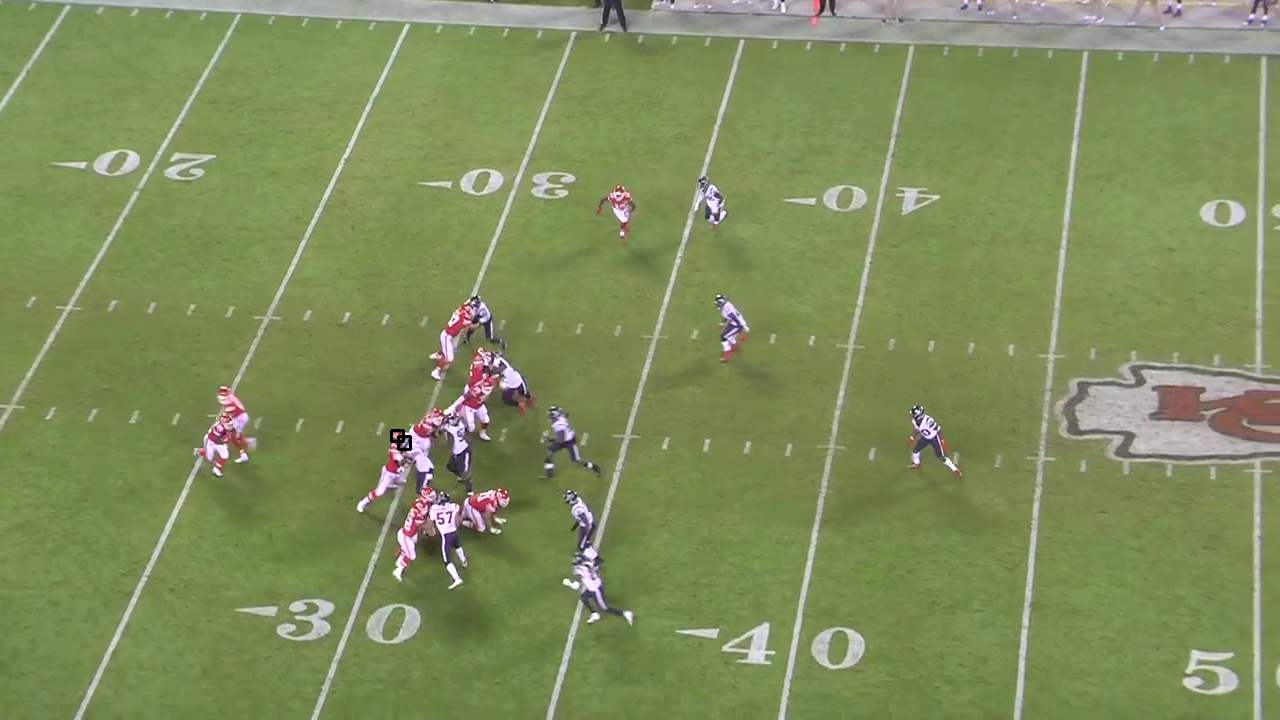

In [ ]:
show_frame_from_contact(df_combo.loc[df_combo.contact==1].iloc[0, :], 'Sideline', show_helmets=True)

## Finding contact region

In order to detect the presence of a contact between two players we will have to focus on the portion of the image interested by the contact. We can find it by using the information of the bounding boxes and making the following assumptions:
- The contacts will likely happen in the space between the two players, i.e. in the space bewteen the helmets.
- In football the contact often happens between hands vs shoulders or hand vs chest. For this reason we need to consider also the region below the helmets.

We start by calculating the region between the helmets. We do this by merging the boxes of the helmets.

In [ ]:
df_combo.loc[:, 'left_s'] = np.minimum(df_combo['left_s_1'], df_combo['left_s_2'])
df_combo.loc[:, 'width_s'] = np.maximum(df_combo['left_s_1'] + df_combo['width_s_1'], df_combo['left_s_2'] + df_combo['width_s_2']) - df_combo['left_s']
df_combo.loc[:, 'top_s'] = np.minimum(df_combo['top_s_1'], df_combo['top_s_2'])
df_combo.loc[:, 'height_s'] = np.maximum(df_combo['top_s_1'] + df_combo['height_s_1'], df_combo['top_s_2'] + df_combo['height_s_2']) - df_combo['top_s']

In [ ]:
df_combo.loc[:, 'left_e'] = np.minimum(df_combo['left_e_1'], df_combo['left_e_2'])
df_combo.loc[:, 'width_e'] = np.maximum(df_combo['left_e_1'] + df_combo['width_e_1'], df_combo['left_e_2'] + df_combo['width_e_2']) - df_combo['left_e']
df_combo.loc[:, 'top_e'] = np.minimum(df_combo['top_e_1'], df_combo['top_e_2'])
df_combo.loc[:, 'height_e'] = np.maximum(df_combo['top_e_1'] + df_combo['height_e_1'], df_combo['top_e_2'] + df_combo['height_e_2']) - df_combo['top_e']

### Everything good? (2)

We show the result of the merge.

Showing frame of game_play 58168_003392, step 12 for players 37084 and 45695


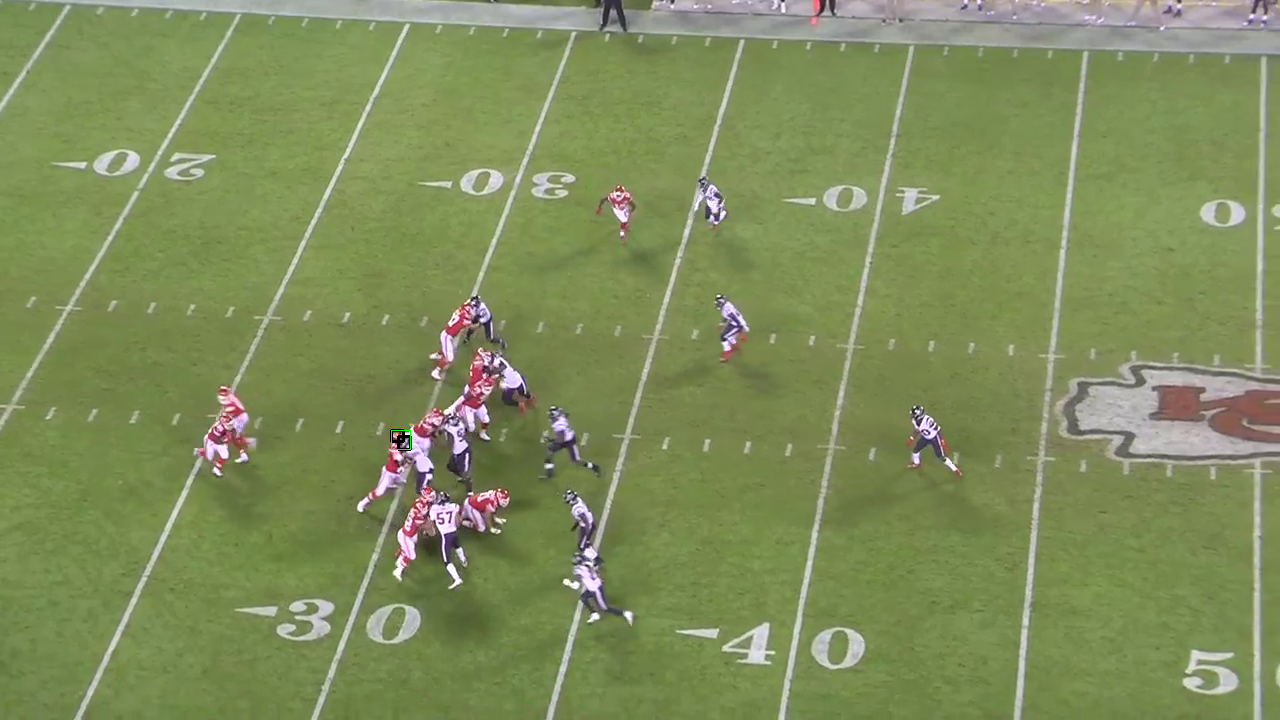

In [ ]:
show_frame_from_contact(df_combo.loc[df_combo.contact==1].iloc[0, :], 'Sideline', show_contact=True)

We proceed, as explained before, by expanding the region to include the chest of the players.

In [ ]:
df_combo.loc[:, 'height_s'] = np.maximum(df_combo['height_s_1'], df_combo['height_s_2']) * 3
df_combo.loc[:, 'height_e'] = np.maximum(df_combo['height_e_1'], df_combo['height_e_2']) * 3

### Everything good? (3)

Here it is possible to see the final contact region.

Showing frame of game_play 58168_003392, step 12 for players 37084 and 45695


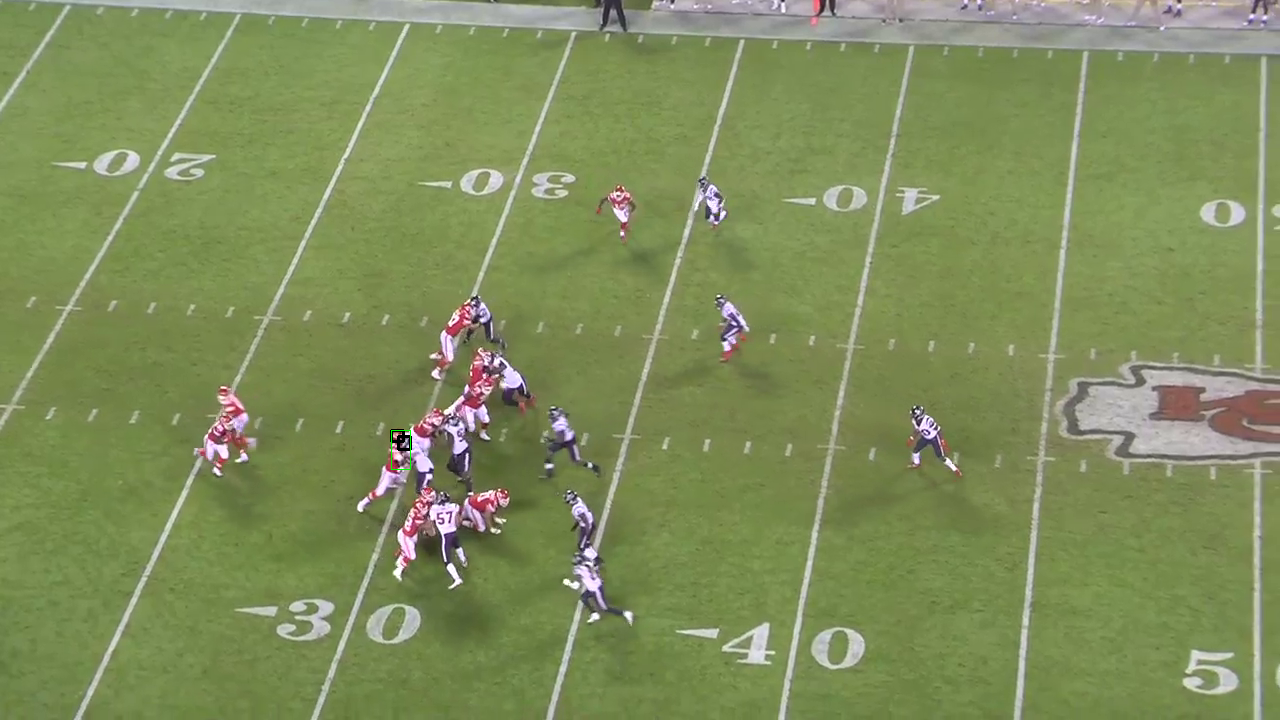

In [ ]:
show_frame_from_contact(df_combo.loc[df_combo.contact==1].iloc[0, :], 'Sideline', show_helmets=True, show_contact=True)

## Converting contact boxes

Our contact boxes are now represented by the combination of top left point, height and width of the boxes.
However, the pytorch functions that we are going to use will require us to represent the box with the top left and bottom right points of it. Therefore, we have to convert them.

In [ ]:
df_combo.rename(columns={'left_s': 'x1_s', 'left_e': 'x1_e', 'top_s': 'y1_s', 'top_e': 'y1_e'}, inplace=True)

In [ ]:
df_combo.loc[:, 'x2_s'] = df_combo['x1_s'] + df_combo['width_s']
df_combo.loc[:, 'y2_s'] = df_combo['y1_s'] + df_combo['height_s']

df_combo.loc[:, 'x2_e'] = df_combo['x1_e'] + df_combo['width_e']
df_combo.loc[:, 'y2_e'] = df_combo['y1_e'] + df_combo['height_e']

In [ ]:
df_combo.drop(['width_s', 'width_e', 'height_s', 'height_e'], axis=1, inplace=True)

In [ ]:
df_combo

game_play  step  nfl_player_id_1  nfl_player_id_2  contact  \
0        58168_003392     0            37084            37211        0   
1        58168_003392     0            37084            38556        0   
2        58168_003392     0            37084            38567        0   
3        58168_003392     0            37084            38590        0   
4        58168_003392     0            37084            39947        0   
...               ...   ...              ...              ...      ...   
1453216  58582_003121     9            52493            52609        0   
1453217  58582_003121     9            52493            52619        0   
1453218  58582_003121     9            52500            52609        0   
1453219  58582_003121     9            52500            52619        0   
1453220  58582_003121     9            52609            52619        0   

             example_id  frame   distance  left_s_1  width_s_1  ...  top_e_2  \
0        58168_003392_0    299   3.794232     484.0       14.0  ...    265.0   
1        58168_003392_0    299  10.530043     484.0       14.0  ...    284.0   
2        58168_003392_0    299   1.543017     484.0       14.0  ...    276.0   
3        58168_003392_0    299   5.431841     484.0       14.0  ...    288.0   
4        58168_003392_0    299   6.886697     484.0       14.0  ...    279.0   
...                 ...    ...        ...       ...        ...  ...      ...   
1453216  58582_003121_9    353  18.231854    1024.0       15.0  ...      NaN   
1453217  58582_003121_9    353  20.671318    1024.0       15.0  ...      NaN   
1453218  58582_003121_9    353   6.854495     535.0       12.0  ...      NaN   
1453219  58582_003121_9    353  33.430289     535.0       12.0  ...      NaN   
1453220  58582_003121_9    353  26.576495     534.0       13.0  ...      NaN   

         height_e_2   x1_s   y1_s   x1_e   y1_e    x2_s   y2_s    x2_e   y2_e  
0              32.0  374.0  464.0  149.0  265.0   498.0  518.0   418.0  361.0  
1              22.0  484.0  282.0  396.0  284.0   558.0  336.0  1240.0  350.0  
2              35.0  439.0  457.0  381.0  276.0   498.0  520.0   418.0  381.0  
3              34.0  468.0  371.0  396.0  288.0   498.0  425.0   833.0  390.0  
4              33.0  474.0  341.0  396.0  279.0   498.0  395.0   967.0  378.0  
...             ...    ...    ...    ...    ...     ...    ...     ...    ...  
1453216         NaN  534.0  171.0    NaN    NaN  1039.0  213.0     NaN    NaN  
1453217         NaN  497.0  316.0    NaN    NaN  1039.0  358.0     NaN    NaN  
1453218         NaN  534.0   86.0    NaN    NaN   547.0  128.0     NaN    NaN  
1453219         NaN  497.0   86.0    NaN    NaN   547.0  125.0     NaN    NaN  
1453220         NaN  497.0  171.0    NaN    NaN   547.0  213.0     NaN    NaN  

[1453221 rows x 32 columns]

### Everything good? (4)

We can visually check that the conversion has been successful!

Showing frame of game_play 58168_003392, step 12 for players 37084 and 45695


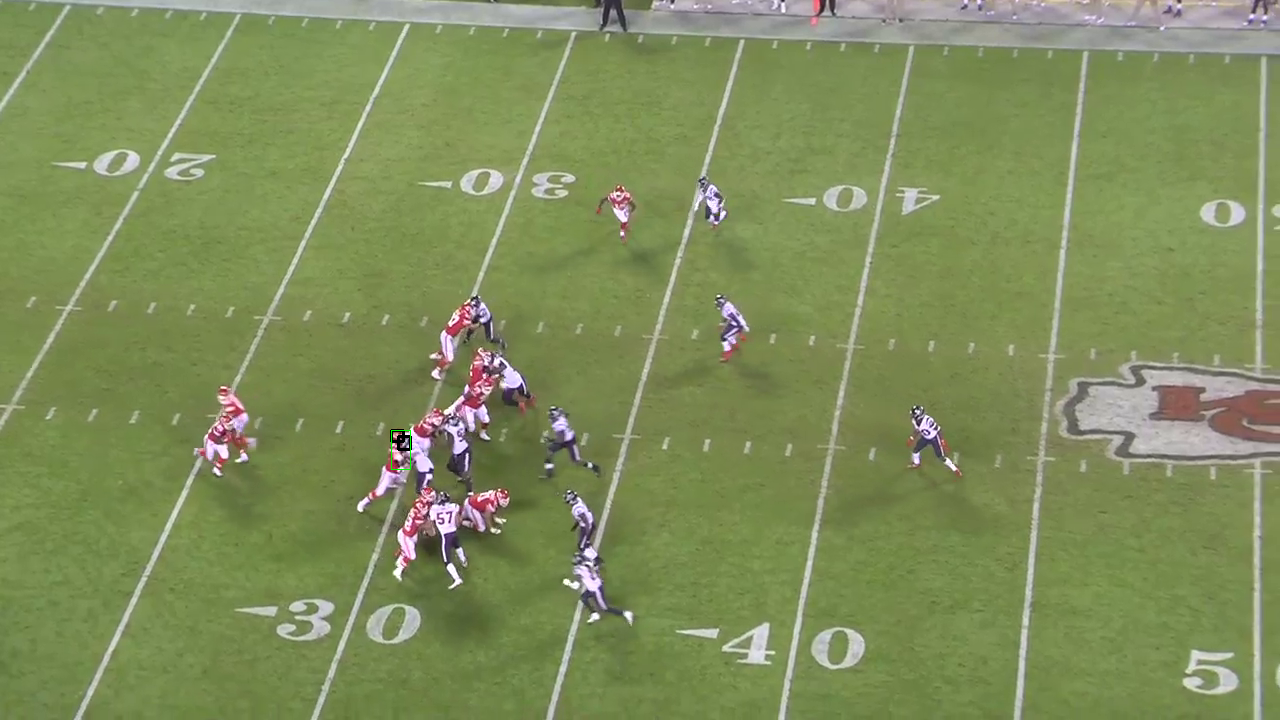

In [ ]:
show_frame_from_contact(df_combo.loc[df_combo.contact==1].iloc[0, :], 'Sideline', show_helmets=True, show_contact=True, are_points=True)

## Train validation split

We proceed by sampling the example ids that will compose the train, validation and test set.

In [ ]:
n_examples = len(examples_metadata)
n_examples

6291

In [ ]:
random_seed = 44
train_id, other_id = train_test_split(examples_metadata.example_id.to_list(), test_size=0.20, random_state=random_seed)
val_id, test_id = train_test_split(other_id, test_size=0.33, random_state=random_seed)

In [ ]:
len(train_id), len(val_id), len(test_id)

(5032, 843, 416)

## Masking contacts

As explained before, we will use the distance to filter out improbabile contacts.

Since we want each gameplay to have the same number of combinations, we will not remove the players that are distant, but we will add a mask feature that tells whether the possible contact has to be processed or not.

We will use as distance threshold the 99th percentile of the distances at which there is a contact (considering only the training set). In this way we have almost 1 of recall and we minimize the risk of not processing true contacts.

I addition to this, we will also not consider contacts that are not visible in any view.

In [ ]:
percentiles = np.percentile(df_combo.loc[(df_combo["example_id"].isin(train_id)) & (df_combo.contact == 1)].distance, [90, 95, 99, 100])
percentiles

array([1.23328017, 1.37427071, 1.74031719, 5.76615123])

In [ ]:
distance_treshold = percentiles[2]
distance_treshold

1.7403171885572246

In [ ]:
df_combo.insert(5, 'loss_mask', False)
df_combo.insert(6, 'sideline_mask', False)
df_combo.insert(7, 'endzone_mask', False)

In [ ]:
df_combo.loc[(df_combo.distance <= distance_treshold) & (df_combo.left_s_1.notna()) & (df_combo.left_s_2.notna()),  'sideline_mask'] = True
df_combo.loc[(df_combo.distance <= distance_treshold) & (df_combo.left_e_1.notna()) & (df_combo.left_e_2.notna()),  'endzone_mask'] = True
df_combo.loc[(df_combo.sideline_mask == True) | (df_combo.endzone_mask == True),  'loss_mask'] = True

In [ ]:
df_combo

game_play  step  nfl_player_id_1  nfl_player_id_2  contact  \
0        58168_003392     0            37084            37211        0   
1        58168_003392     0            37084            38556        0   
2        58168_003392     0            37084            38567        0   
3        58168_003392     0            37084            38590        0   
4        58168_003392     0            37084            39947        0   
...               ...   ...              ...              ...      ...   
1453216  58582_003121     9            52493            52609        0   
1453217  58582_003121     9            52493            52619        0   
1453218  58582_003121     9            52500            52609        0   
1453219  58582_003121     9            52500            52619        0   
1453220  58582_003121     9            52609            52619        0   

         loss_mask  sideline_mask  endzone_mask      example_id  frame  ...  \
0            False          False         False  58168_003392_0    299  ...   
1            False          False         False  58168_003392_0    299  ...   
2             True           True          True  58168_003392_0    299  ...   
3            False          False         False  58168_003392_0    299  ...   
4            False          False         False  58168_003392_0    299  ...   
...            ...            ...           ...             ...    ...  ...   
1453216      False          False         False  58582_003121_9    353  ...   
1453217      False          False         False  58582_003121_9    353  ...   
1453218      False          False         False  58582_003121_9    353  ...   
1453219      False          False         False  58582_003121_9    353  ...   
1453220      False          False         False  58582_003121_9    353  ...   

         top_e_2  height_e_2   x1_s   y1_s   x1_e   y1_e    x2_s   y2_s  \
0          265.0        32.0  374.0  464.0  149.0  265.0   498.0  518.0   
1          284.0        22.0  484.0  282.0  396.0  284.0   558.0  336.0   
2          276.0        35.0  439.0  457.0  381.0  276.0   498.0  520.0   
3          288.0        34.0  468.0  371.0  396.0  288.0   498.0  425.0   
4          279.0        33.0  474.0  341.0  396.0  279.0   498.0  395.0   
...          ...         ...    ...    ...    ...    ...     ...    ...   
1453216      NaN         NaN  534.0  171.0    NaN    NaN  1039.0  213.0   
1453217      NaN         NaN  497.0  316.0    NaN    NaN  1039.0  358.0   
1453218      NaN         NaN  534.0   86.0    NaN    NaN   547.0  128.0   
1453219      NaN         NaN  497.0   86.0    NaN    NaN   547.0  125.0   
1453220      NaN         NaN  497.0  171.0    NaN    NaN   547.0  213.0   

           x2_e   y2_e  
0         418.0  361.0  
1        1240.0  350.0  
2         418.0  381.0  
3         833.0  390.0  
4         967.0  378.0  
...         ...    ...  
1453216     NaN    NaN  
1453217     NaN    NaN  
1453218     NaN    NaN  
1453219     NaN    NaN  
1453220     NaN    NaN  

[1453221 rows x 35 columns]

### Everything good? (5)


In [ ]:
assert len(df_combo[(df_combo.loss_mask == True) & (df_combo.sideline_mask == False) & (df_combo.endzone_mask == False)]) == 0

### Drop examples no good for training

It is possible that after the masking, there are training examples that contain only combination with *mask=false*. This examples will not contribute in the training, meaning we can eliminate them.

In [ ]:
new_examples_metadata = df_combo.groupby(by='example_id')['loss_mask'].sum().reset_index()
examples_metadata.loc[:, 'loss_mask'] = new_examples_metadata.loc[:, 'loss_mask']
examples_metadata = examples_metadata.loc[examples_metadata.loss_mask != 0]

examples_metadata

example_id     game_play  step  frame  loss_mask
0      58168_003392_0  58168_003392     0    299          6
1     58168_003392_12  58168_003392    12    371         14
2     58168_003392_15  58168_003392    15    389         12
3     58168_003392_18  58168_003392    18    407         14
4     58168_003392_21  58168_003392    21    425         16
...               ...           ...   ...    ...        ...
6286  58582_003121_81  58582_003121    81    785          2
6287  58582_003121_84  58582_003121    84    803          2
6288  58582_003121_87  58582_003121    87    821          1
6289   58582_003121_9  58582_003121     9    353          6
6290  58582_003121_90  58582_003121    90    839          1

[5791 rows x 5 columns]

In [ ]:
print(f'Average number of contacts to be processed per image: {np.mean(examples_metadata.loss_mask)}')

Average number of contacts to be processed per image: 10.40338456225177


### Drop unused columns

In [ ]:
# df_combo.drop(['distance', 'left_s_1', 'left_s_2', 'left_e_1', 'left_e_2', 'width_s_1', 'width_s_2', 'width_e_1', 'width_e_2', 'top_s_1', 'top_s_2', 'top_e_1', 'top_e_2', 'height_s_1', 'height_s_2', 'height_e_1', 'height_e_2'], axis=1, inplace=True)
# df_combo

## Split dataframes

Now that we got rid of the useless training examples, we can split both the example metadata dataframe and the combo dataframe into train set and validation using the example ids that we computed before.

In [ ]:
train_metadata = examples_metadata.loc[examples_metadata["example_id"].isin(train_id)].drop('loss_mask', axis=1)
val_metadata = examples_metadata.loc[examples_metadata["example_id"].isin(val_id)].drop('loss_mask', axis=1)
test_metadata = examples_metadata.loc[examples_metadata["example_id"].isin(test_id)].drop('loss_mask', axis=1)

train_df = train_metadata.merge(df_combo, on=['example_id', 'game_play', 'step', 'frame'], how='left')
val_df = val_metadata.merge(df_combo, on=['example_id', 'game_play', 'step', 'frame'], how='left')
test_df = test_metadata.merge(df_combo, on=['example_id', 'game_play', 'step', 'frame'], how='left')

In [ ]:
len(train_metadata), len(val_metadata), len(test_metadata)

(4638, 775, 378)

# Dataframes to csv

Now that the preprocessing is over we can save the final dataframes into csv files.

In [ ]:
path_train = f'{BASE_DIR}/1280p/dataframes/step{STEP_NUMBER}/train_df_s.csv'
path_val = f'{BASE_DIR}/1280p/dataframes/step{STEP_NUMBER}/val_df_s.csv'
path_test = f'{BASE_DIR}/1280p/dataframes/step{STEP_NUMBER}/test_df_s.csv'

path_train_metadata = f'{BASE_DIR}/metadata/step{STEP_NUMBER}/train_metadata_s.csv'
path_val_metadata = f'{BASE_DIR}/metadata/step{STEP_NUMBER}/val_metadata_s.csv'
path_test_metadata = f'{BASE_DIR}/metadata/step{STEP_NUMBER}/test_metadata_s.csv'

In [ ]:
train_df.to_csv(path_train)
val_df.to_csv(path_val)
test_df.to_csv(path_test)

train_metadata.to_csv(path_train_metadata)
val_metadata.to_csv(path_val_metadata)
test_metadata.to_csv(path_test_metadata)

# Videos and Bounding Box resizing

As mentioned at the beginning of the notebook, we decided to process the image also at a smaller resolution. In this way it was possible to use more training examples.

In the following cells we halve the spatial resolutin of the videos and consequently also the spatial features of the combo dataframe.

In [ ]:
path_train = f'{BASE_DIR}/1280p/dataframes/step{STEP_NUMBER}/train_df_s.csv'
path_val = f'{BASE_DIR}/1280p/dataframes/step{STEP_NUMBER}/val_df_s.csv'
path_test = f'{BASE_DIR}/1280p/dataframes/step{STEP_NUMBER}/test_df_s.csv'

In [ ]:
path_train_res = f'{BASE_DIR}/640p/dataframes/step{STEP_NUMBER}/train_df_s.csv'
path_val_res = f'{BASE_DIR}/640p/dataframes/step{STEP_NUMBER}/val_df_s.csv'
path_test_res = f'{BASE_DIR}/640p/dataframes/step{STEP_NUMBER}/test_df_s.csv'

In [ ]:
train_df = pd.read_csv(path_train)
val_df = pd.read_csv(path_val)
test_df = pd.read_csv(path_test)

In [ ]:
def resize_video(video_path: str, output_dir: str, factor: float=0.5):

  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  success, frame = cap.read()

  new_size = (np.round(frame.shape[1]*factor).astype(np.int32), np.round(frame.shape[0]*factor).astype(np.int32))

  fourcc = cv2.VideoWriter_fourcc(*"mp4v")
  writer = cv2.VideoWriter(
      output_dir,
      fourcc,
      fps,
      new_size
  )

  while success:
    frame = cv2.resize(frame, new_size, interpolation=cv2.INTER_AREA)
    writer.write(frame)
    success, frame = cap.read()

  cap.release()
  writer.release()


In [ ]:
names = ['left_s_1', 'width_s_1', 'top_s_1', 'height_s_1', 'left_s_2',
       'width_s_2', 'top_s_2', 'height_s_2', 'left_e_1', 'width_e_1',
       'top_e_1', 'height_e_1', 'left_e_2', 'width_e_2', 'top_e_2',
       'height_e_2', 'x1_s', 'y1_s', 'x1_e', 'y1_e', 'x2_s', 'y2_s', 'x2_e',
       'y2_e']

def resize_dataset(dataset: pd.DataFrame, output_dir: str, part_dir, factor=0.5):

  game_plays = dataset.game_play.unique()
  progress_bar = tqdm(range(len(game_plays) * 2))

  for game_play in game_plays:
    for view in ["Sideline", "Endzone"]:
      if os.path.exists(f"{BASE_DIR}/1280p/{part_dir}/{game_play}_{view}.mp4"):
        progress_bar.set_postfix(video="Already Done")
      else:
        progress_bar.set_postfix(video=f"{game_play}_{view}.mp4")
        resize_video(
          f"{BASE_DIR}/1280p/{part_dir}/{game_play}_{view}.mp4",
          f"{output_dir}/{game_play}_{view}.mp4",
          factor=factor
        )
      progress_bar.update(1)

  print("°" * 120)
  print("Updating dataset values")
  dataset[names] = dataset[names].apply(lambda x: np.round(x*factor))

In [ ]:
train_df[names] = train_df[names].apply(lambda x: x//2)

In [ ]:
val_df[names] = val_df[names].apply(lambda x: x//2)

In [ ]:
test_df[names] = test_df[names].apply(lambda x: x//2)

In [ ]:
resize_dataset(train_df, f"{BASE_DIR}/640p/train", "train")

  0%|          | 0/478 [00:00<?, ?it/s]

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Updating dataset values


In [ ]:
train_df.to_csv(path_train_res)

In [ ]:
resize_dataset(test_df, f"{BASE_DIR}/640p/test", "train")

  0%|          | 0/374 [00:00<?, ?it/s]

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Updating dataset values


In [ ]:
test_df.to_csv(path_test_res)

In [ ]:
resize_dataset(val_df, f"{BASE_DIR}/640p/train", "train")

  0%|          | 0/452 [00:00<?, ?it/s]

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Updating dataset values


In [ ]:
val_df.to_csv(path_val_res)

## Check correctness

We can visually check the correctness of the operation by visually comparing the same possible contact at the two different resolutions.

In [ ]:
train_df_res = pd.read_csv(path_train_res)

In [ ]:
train_df = pd.read_csv(path_train)

In [ ]:
datas = train_df.iloc[10]

In [ ]:
datas_res = train_df_res.iloc[10]

In [ ]:
cap = cv2.VideoCapture(f"{BASE_DIR}/1280p/train/{datas['game_play']}_Sideline.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, datas.frame)
res, frame = cap.read()

cap = cv2.VideoCapture(f"{BASE_DIR}/640p/train/{datas_res['game_play']}_Sideline.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, datas_res.frame)
res, frame_res = cap.read()

In [ ]:
frame = cv2.rectangle(frame,
                      (datas["x1_s"].astype(int), datas["y1_s"].astype(int)),
                      (datas["x2_s"].astype(int), datas["y2_s"].astype(int)),
                      (255,0,0), 2)

frame_res = cv2.rectangle(frame_res,
                          (datas_res["x1_s"].astype(np.int32), datas_res["y1_s"].astype(np.int32)),
                          (datas_res["x2_s"].astype(np.int32), datas_res["y2_s"].astype(np.int32)),
                          (255,0,0), 1)

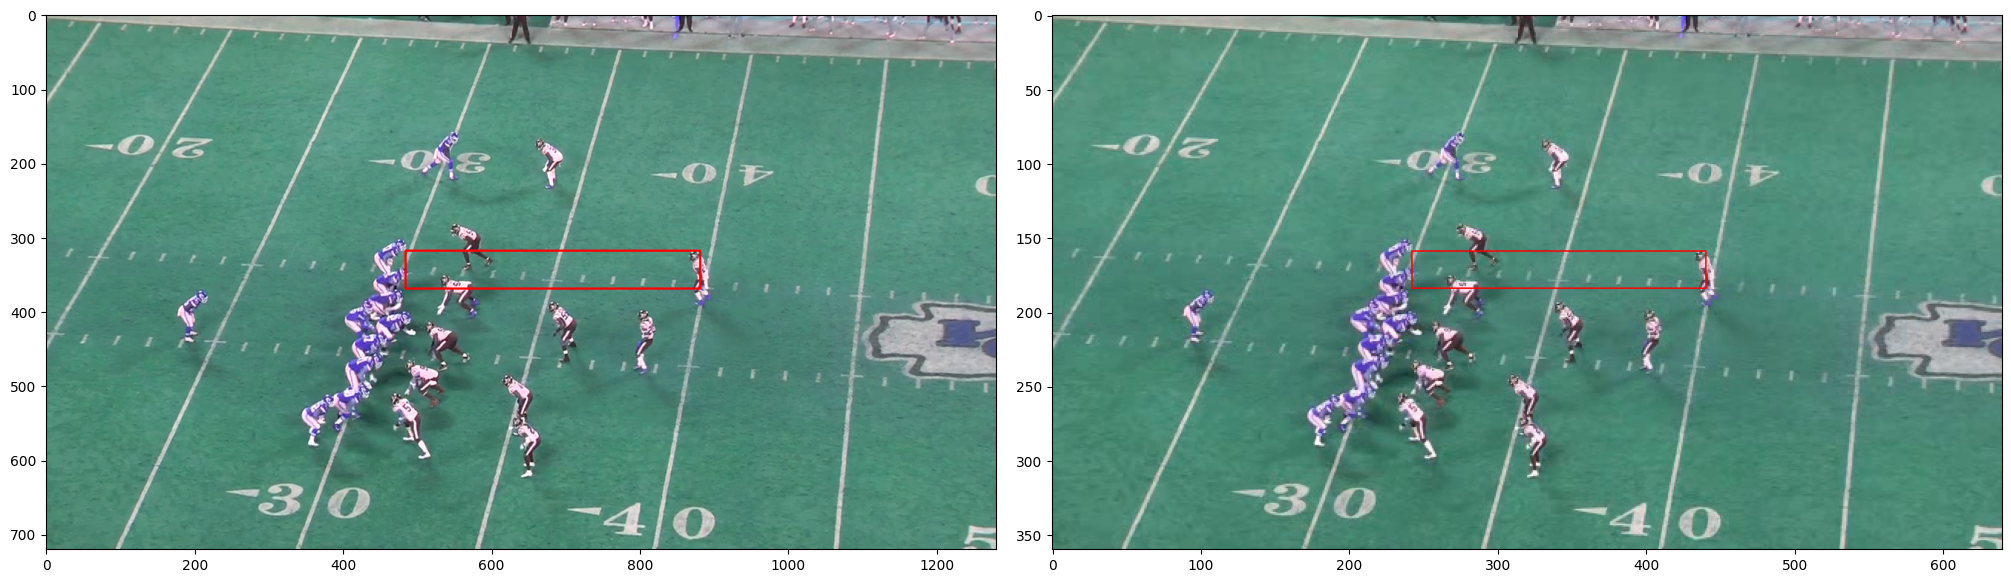

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
subfigures = fig.subplots(1,2)
subfigures[0].imshow(frame)
subfigures[1].imshow(frame_res)

# Frame extraction

In this portion of the notebook we extract the relevant frames for our training examples and we save them in hdf5 files.

In [ ]:
QUALITY = "640p"

if QUALITY == "640p":

  HEIGHT = 360
  WIDTH = 640

if QUALITY == "1280p":

  HEIGHT = 720
  WIDTH = 1280


In [ ]:
NUM_STEPS = 3

In [ ]:
train_metadata = pd.read_csv(f'{BASE_DIR}/metadata/step{NUM_STEPS}/train_metadata_s.csv')
val_metadata = pd.read_csv(f'{BASE_DIR}/metadata/step{NUM_STEPS}/val_metadata_s.csv')
test_metadata = pd.read_csv(f'{BASE_DIR}/metadata/step{NUM_STEPS}/test_metadata_s.csv')

train_df = pd.read_csv(f'{BASE_DIR}/{QUALITY}/dataframes/step{NUM_STEPS}/train_df_s.csv')
val_df = pd.read_csv(f'{BASE_DIR}/{QUALITY}/dataframes/step{NUM_STEPS}/val_df_s.csv')
test_df = pd.read_csv(f'{BASE_DIR}/{QUALITY}/dataframes/step{NUM_STEPS}/test_df_s.csv')

In [ ]:
split_dict = {'train': train_metadata,
              'val': val_metadata,
              'test': test_metadata
              }
df_dict = {
    'train' : train_df,
    'val': val_df,
    'test' : test_df
}

In [ ]:
split = 'train'
len_split = len(split_dict[split])
progress_bar = tqdm(range(len_split))

frames_sideline = np.empty((len_split, HEIGHT, WIDTH, 3), dtype=np.uint8)
frames_endzone = np.empty((len_split, HEIGHT, WIDTH, 3), dtype=np.uint8)
keys = []

i = 0

split_metadata = split_dict[split]

mapping_indexes = {}
for game_play in split_metadata.game_play.unique():
  temp_gp_df = split_metadata[split_dict[split].game_play == game_play]

  path_sideline = f'{BASE_DIR}/{QUALITY}/train/{game_play}_Sideline.mp4'
  path_endzone = f'{BASE_DIR}/{QUALITY}/train/{game_play}_Endzone.mp4'

  #cap_sideline = cv2.VideoCapture(path_sideline)
  #cap_endzone = cv2.VideoCapture(path_endzone)

  inner_dict = {}
  for example in temp_gp_df.itertuples(index=False):

    #cap_sideline.set(cv2.CAP_PROP_POS_FRAMES, example.frame)
    #cap_endzone.set(cv2.CAP_PROP_POS_FRAMES, example.frame)

    #ret_sideline, frame_sideline = cap_sideline.read()
    #ret_endzone, frame_endzone = cap_endzone.read()

    #frames_sideline[i] = frame_sideline if ret_sideline else np.zeros((HEIGHT, WIDTH, 3))
    #frames_endzone[i] = frame_endzone if ret_endzone else np.zeros((HEIGHT, WIDTH, 3))

    #keys.append(example.example_id)
    inner_dict[example.frame] = i

    # if i % 10 == 0:
    #   cv2_imshow(frame_endzone)

    i += 1
    progress_bar.update(1)

  mapping_indexes[game_play] = inner_dict
  #cap_sideline.release()
  #cap_endzone.release()

  0%|          | 0/4634 [00:00<?, ?it/s]

In [ ]:
train_df["mapping_index"] = [mapping_indexes[train_df.iloc[x].game_play][train_df.iloc[x].frame] for x in range(len(train_df))]

In [ ]:
train_df.to_csv(f'{BASE_DIR}/{QUALITY}/dataframes/step{NUM_STEPS}/train_df_s.csv')

In [ ]:
# Create a new HDF5 file
with h5py.File(f"{BASE_DIR}/{QUALITY}/H5/step{STEP_NUMBER}/{split}_s.h5", "w") as f:
  # Create a dataset in the file
  dataset_sideline = f.create_dataset("frames_sideline", data=frames_sideline)
  dataset_endzone = f.create_dataset("frames_endzone", data=frames_endzone)

  dt = h5py.string_dtype(encoding='utf-8')
  dataset_key = f.create_dataset("keys", data=keys, dtype=dt)


# Conclusion

The preprocessing phase is over: we have the data and images of possible contacts at two different resolutions. Now we can use the data produced to train the networks. The training phase can be analyzed in the *ML4CV_project_work_nets* notebook.